In [ ]:
# prompt: print the directories in my project directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Project'):
    print(dirname)


/content/drive/MyDrive/Project
/content/drive/MyDrive/Project/malignant
/content/drive/MyDrive/Project/benign
/content/drive/MyDrive/Project/.ipynb_checkpoints


In [ ]:
# prompt: remove .ipynb_checkpoints from the directory

import os
import shutil

for dirname, _, filenames in os.walk('/content/drive/MyDrive/Project'):
    if '.ipynb_checkpoints' in dirname:
      shutil.rmtree(dirname)


In [ ]:
# prompt: now print the number of directories

import os
import shutil

count = 0
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Project'):
    if '.ipynb_checkpoints' not in dirname:
      count += 1

print(count)


3


In [ ]:
# prompt: print the names of directories in my project directory

import os
import shutil

for dirname, _, filenames in os.walk('/content/drive/MyDrive/Project'):
  if '.ipynb_checkpoints' not in dirname:
    print(dirname)


/content/drive/MyDrive/Project
/content/drive/MyDrive/Project/malignant
/content/drive/MyDrive/Project/benign


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Set the directory for the dataset
dataset_dir = '/content/drive/MyDrive/Project'

# ImageDataGenerator for preprocessing and data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Generators
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(299, 299),  # Xception requires 299x299 input size
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    subset='validation'
)

# Load Xception without the top layers
base_model = Xception(weights=None, include_top=False, input_shape=(299, 299, 1))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Dropout for regularization
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_path = "/content/drive/MyDrive/Project/best_xception_model.keras"
checkpoint_cb = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb]
)

# Evaluate the model
accuracy = model.evaluate(validation_generator)
print(f"Validation accuracy: {accuracy}")

# Load the best model
best_model = tf.keras.models.load_model(checkpoint_path)

# Predict on the validation set
validation_generator.reset()
y_pred = best_model.predict(validation_generator)
y_pred = np.round(y_pred).astype(int).flatten()
y_true = validation_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_plot_labels = ['benign', 'malignant']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_plot_labels, yticklabels=cm_plot_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=cm_plot_labels))

# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Epoch 1/15
123/250 [=============>................] - ETA: 2:01:34 - loss: 0.4740 - accuracy: 0.7812

In [1]:
import os
import shutil
import random

# Set seed for reproducibility
random.seed(42)

# Paths
original_dataset_dir = '/content/drive/MyDrive/Project'
base_dir = 'dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

# Create new directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Categories
categories = ['benign', 'malignant']

for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)

    category_dir = os.path.join(original_dataset_dir, category)
    images = os.listdir(category_dir)
    random.shuffle(images)

    # Split the images into 80% training and 20% validation
    train_split = int(0.8 * len(images))
    train_images = images[:train_split]
    val_images = images[train_split:]

    for image in train_images:
        src = os.path.join(category_dir, image)
        dst = os.path.join(train_dir, category, image)
        shutil.copyfile(src, dst)

    for image in val_images:
        src = os.path.join(category_dir, image)
        dst = os.path.join(val_dir, category, image)
        shutil.copyfile(src, dst)

print("Dataset restructured successfully.")

Dataset restructured successfully.


SE-RESNET

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/20
250/250 [==============================] - ETA: 0s - loss: 0.5153 - accuracy: 0.7350
Epoch 1: val_accuracy improved from -inf to 0.50504, saving model to /content/drive/MyDrive/Project/best_se_resnet_model.keras
250/250 [==============================] - 116s 194ms/step - loss: 0.5153 - accuracy: 0.7350 - val_loss: 9.9742 - val_accuracy: 0.5050 - lr: 0.0010
Epoch 2/20
250/250 [==============================] - ETA: 0s - loss: 0.4751 - accuracy: 0.7624
Epoch 2: val_accuracy did not improve from 0.50504
250/250 [==============================] - 45s 180ms/step - loss: 0.4751 - accuracy: 0.7624 - val_loss: 5.9068 - val_accuracy: 0.5040 - lr: 0.0010
Epoch 3/20
250/250 [==============================] - ETA: 0s - loss: 0.4441 - accuracy: 0.7839
Epoch 3: val_accuracy improved from 0.50504 to 0.51210, saving model to /content/drive/MyDrive/Project/best_se_resnet_model.keras
250/250 [================

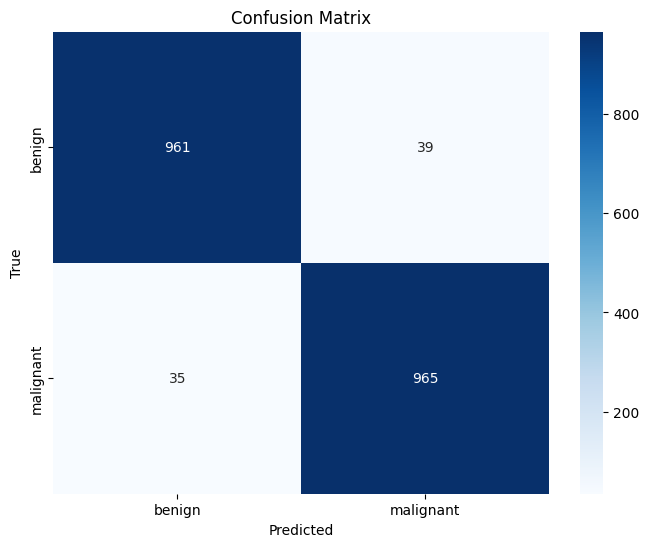

              precision    recall  f1-score   support

      benign       0.96      0.96      0.96      1000
   malignant       0.96      0.96      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



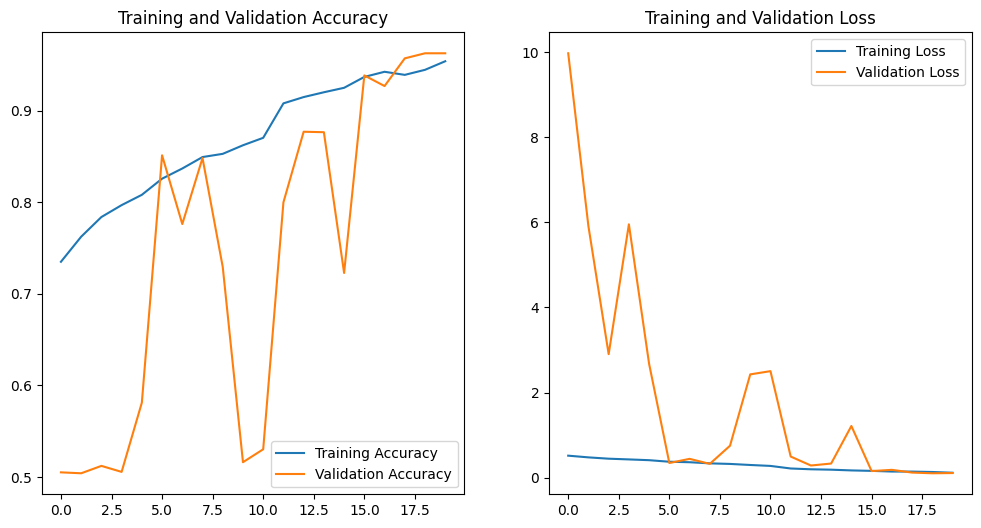

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D, Dense, Multiply, Add, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ImageDataGenerator for preprocessing and data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    '/content/dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    '/content/dataset/validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False
)

# Define SE Block
def se_block(input_tensor, reduction=16):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(filters // reduction, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = tf.keras.layers.Reshape((1, 1, filters))(se)
    return Multiply()([input_tensor, se])

# Define SE-ResNet Block
def se_resnet_block(input_tensor, filters, kernel_size=3, stride=1):
    x = Conv2D(filters, kernel_size, padding='same', strides=stride)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    se = se_block(x)

    if stride != 1 or input_tensor.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(input_tensor)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    x = Add()([shortcut, se])
    x = Activation('relu')(x)
    return x

# Define SE-ResNet Model with Dropout
def build_se_resnet(input_shape=(224, 224, 1), num_classes=1):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    for filters in [64, 128, 256, 512]:
        x = se_resnet_block(x, filters, stride=2)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Adding dropout to reduce overfitting
    outputs = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

# Instantiate the SE-ResNet model
model = build_se_resnet()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint_path = "/content/drive/MyDrive/Project/best_se_resnet_model.keras"
checkpoint_cb = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb]
)

# Evaluate the model
accuracy = model.evaluate(validation_generator)
print(f"Validation accuracy: {accuracy}")

# Load the best model
best_model = tf.keras.models.load_model(checkpoint_path)

# Predict on the validation set
validation_generator.reset()
y_pred = best_model.predict(validation_generator)
y_pred = np.round(y_pred).astype(int).flatten()
y_true = validation_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_plot_labels = ['benign', 'malignant']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_plot_labels, yticklabels=cm_plot_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=cm_plot_labels))

# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Xception

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/20
250/250 [==============================] - ETA: 0s - loss: 0.3452 - accuracy: 0.8360
Epoch 1: val_accuracy improved from -inf to 0.84375, saving model to /content/drive/MyDrive/Project/best_xception_model.keras
250/250 [==============================] - 182s 635ms/step - loss: 0.3452 - accuracy: 0.8360 - val_loss: 0.6293 - val_accuracy: 0.8438 - lr: 0.0010
Epoch 2/20
250/250 [==============================] - ETA: 0s - loss: 0.1653 - accuracy: 0.9306
Epoch 2: val_accuracy improved from 0.84375 to 0.89264, saving model to /content/drive/MyDrive/Project/best_xception_model.keras
250/250 [==============================] - 157s 628ms/step - loss: 0.1653 - accuracy: 0.9306 - val_loss: 0.3575 - val_accuracy: 0.8926 - lr: 0.0010
Epoch 3/20
250/250 [==============================] - ETA: 0s - loss: 0.0894 - accuracy: 0.9688
Epoch 3: val_accuracy did not improve from 0.89264
250/250 [=================

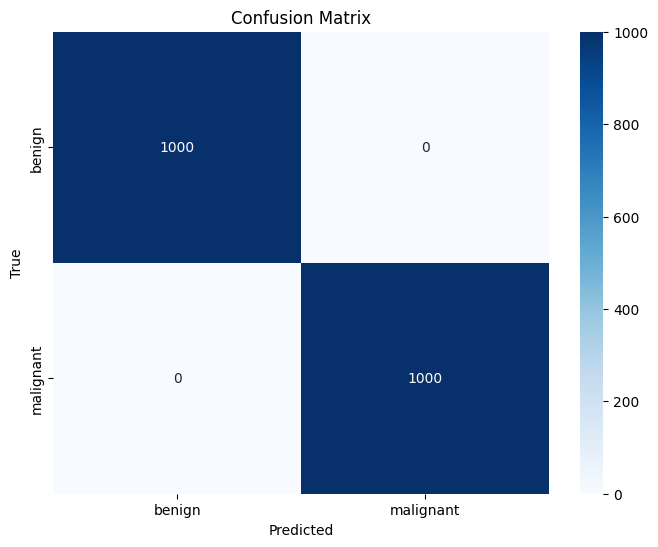

              precision    recall  f1-score   support

      benign       1.00      1.00      1.00      1000
   malignant       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



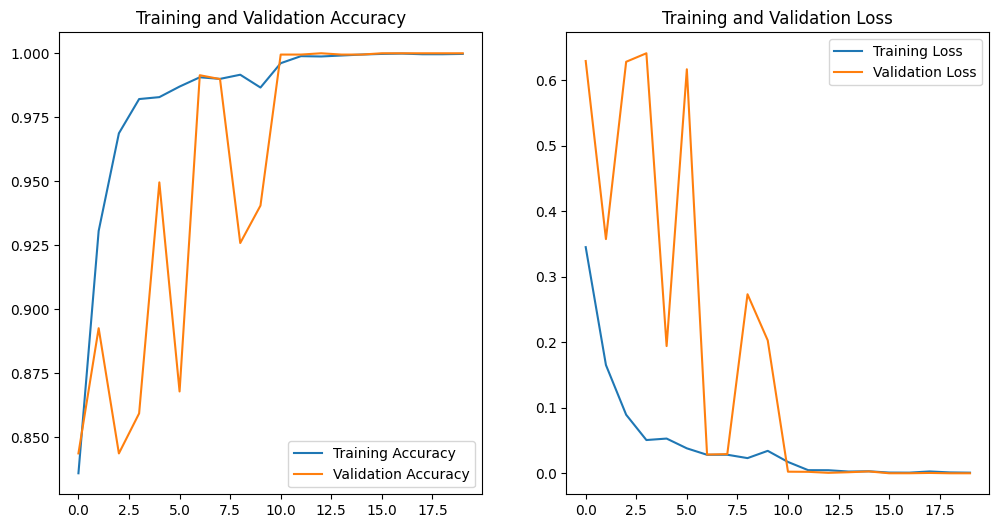

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation data should only be rescaled
val_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    '/content/dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',  # Convert grayscale images to RGB
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    '/content/dataset/validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',  # Convert grayscale images to RGB
    shuffle=False
)

# Load Xception without the top layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Dropout for regularization
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_path = "/content/drive/MyDrive/Project/best_xception_model.keras"
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
checkpoint_cb = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb]
)

# Evaluate the model
accuracy = model.evaluate(validation_generator)
print(f"Validation accuracy: {accuracy}")

# Load the best model
best_model = tf.keras.models.load_model(checkpoint_path)

# Predict on the validation set
validation_generator.reset()
y_pred = best_model.predict(validation_generator)
y_pred = np.round(y_pred).astype(int).flatten()
y_true = validation_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_plot_labels = ['benign', 'malignant']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_plot_labels, yticklabels=cm_plot_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=cm_plot_labels))

# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
